In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,GRU
from tensorflow.keras.optimizers import Adam

In [ ]:
print(tf.__version__)

2.17.1


In [ ]:
# GPU configuration
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    print("GPU is available and configured")
else:
    print("No GPU devices found, using CPU")

GPU is available and configured


In [ ]:
print(tf.config.get_visible_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
print("GPU?: ", tf.config.list_physical_devices('GPU'))

GPU?:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
path='/content/drive/MyDrive/LAST_DATA.csv'

In [ ]:
df=pd.read_csv(path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104361 entries, 0 to 104360
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DATETIME      104361 non-null  object 
 1   RUZGARYON     104361 non-null  float64
 2   RUZGARHIZ     104361 non-null  float64
 3   SICKURU       104361 non-null  float64
 4   NISPINEM      104361 non-null  float64
 5   BASINCAKTUEL  104361 non-null  float64
 6   HADISE0       104361 non-null  object 
 7   HADISE1       104361 non-null  object 
 8   GHADISE0      104361 non-null  object 
 9   BLT0CINS      104361 non-null  float64
 10  BLT0YUK       104361 non-null  float64
 11  AY            104361 non-null  int64  
 12  SAAT          104361 non-null  int64  
 13  MEVSIM        104361 non-null  int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 11.1+ MB


In [ ]:
df['DATETIME']=pd.to_datetime(df['DATETIME'])
df.set_index('DATETIME',inplace=True)


In [ ]:
df.head()

,RUZGARYON,RUZGARHIZ,SICKURU,NISPINEM,BASINCAKTUEL,HADISE0,HADISE1,GHADISE0,BLT0CINS,BLT0YUK,AY,SAAT,MEVSIM
DATETIME,,,,,,,,,,,,,
2016-01-01 00:20:00,240.0,7.0,-0.6,95.0,1016.3,-SHSN,,,7.0,900.0,1,0,4
2016-01-01 00:50:00,240.0,7.0,-0.8,97.0,1016.4,-SHSN,,,7.0,900.0,1,0,4
2016-01-01 01:20:00,240.0,7.0,-0.9,97.0,1016.3,-SHSN,,,7.0,1000.0,1,1,4
2016-01-01 01:50:00,230.0,8.0,-0.9,97.0,1016.4,-SHSN,,,7.0,900.0,1,1,4
2016-01-01 02:20:00,230.0,9.0,-0.7,94.0,1016.3,-SHSN,,,8.0,2800.0,1,2,4


In [ ]:
    # Get numeric and categorical columns
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
categorical_features = df.select_dtypes(include=['object', 'category']).columns
target_features = ['NISPINEM']

In [ ]:
encoder=OneHotEncoder(sparse_output=False, drop='first')

In [ ]:
categorical_data=df[categorical_features]
encoded_data = pd.DataFrame(encoder.fit_transform(df[categorical_features]),
                                      columns=encoder.get_feature_names_out(categorical_features),
                                      index=df.index)

In [ ]:
new_df= pd.concat([df,encoded_data],axis=1)

In [ ]:
new_df = new_df.drop(columns=categorical_features)

In [ ]:
new_df=new_df.astype('float32')

In [ ]:
new_df=new_df.resample('h').mean().ffill()

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53911 entries, 2016-01-01 00:00:00 to 2022-02-24 06:00:00
Freq: h
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   RUZGARYON          53911 non-null  float32
 1   RUZGARHIZ          53911 non-null  float32
 2   SICKURU            53911 non-null  float32
 3   NISPINEM           53911 non-null  float32
 4   BASINCAKTUEL       53911 non-null  float32
 5   BLT0CINS           53911 non-null  float32
 6   BLT0YUK            53911 non-null  float32
 7   AY                 53911 non-null  float32
 8   SAAT               53911 non-null  float32
 9   MEVSIM             53911 non-null  float32
 10  HADISE0_+DZ        53911 non-null  float32
 11  HADISE0_+RA        53911 non-null  float32
 12  HADISE0_+SHRA      53911 non-null  float32
 13  HADISE0_+SHSN      53911 non-null  float32
 14  HADISE0_+TSRA      53911 non-null  float32
 15  HADISE0_-DZ        53911 no

In [ ]:
new_df.tail()

,RUZGARYON,RUZGARHIZ,SICKURU,NISPINEM,BASINCAKTUEL,BLT0CINS,BLT0YUK,AY,SAAT,MEVSIM,...,GHADISE0_RESHRA,GHADISE0_RESHRASN,GHADISE0_RESHSN,GHADISE0_RESHSNGR,GHADISE0_RESHSNRA,GHADISE0_RETS,GHADISE0_RETSGRRA,GHADISE0_RETSRA,GHADISE0_RETSSNGR,GHADISE0_RETSSNRA
DATETIME,,,,,,,,,,,,,,,,,,,,,
2022-02-24 02:00:00,139.5,5.0,15.049999,42.0,1010.900024,8.0,3500.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-24 03:00:00,99.0,3.5,15.900001,38.5,1010.599976,8.0,3500.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-24 04:00:00,185.0,3.5,16.100000,36.5,1010.599976,8.0,3500.0,2.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-24 05:00:00,99.0,1.5,15.200000,49.5,1011.049988,8.0,3500.0,2.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-24 06:00:00,300.0,11.0,12.000000,77.0,1011.599976,8.0,3500.0,2.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df['NISPINEM'].describe()

,NISPINEM
count,104361.000000
mean,73.037509
std,14.347807
min,9.000000
25%,66.000000
50%,75.000000
75%,83.000000
max,100.000000


In [ ]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(new_df), columns=new_df.columns, index=new_df.index)


In [ ]:
scaled_df.head()

,RUZGARYON,RUZGARHIZ,SICKURU,NISPINEM,BASINCAKTUEL,BLT0CINS,BLT0YUK,AY,SAAT,MEVSIM,...,GHADISE0_RESHRA,GHADISE0_RESHRASN,GHADISE0_RESHSN,GHADISE0_RESHSNGR,GHADISE0_RESHSNRA,GHADISE0_RETS,GHADISE0_RETSGRRA,GHADISE0_RETSRA,GHADISE0_RETSSNGR,GHADISE0_RETSSNRA
DATETIME,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.666667,0.333333,0.056194,0.956044,0.618484,0.250,0.195122,0.0,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,0.652778,0.357143,0.051086,0.967033,0.618484,0.250,0.207317,0.0,0.043478,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,0.638889,0.380952,0.054917,0.934066,0.618484,0.375,0.500000,0.0,0.086957,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,0.708333,0.285714,0.060026,0.901099,0.632702,0.375,0.390244,0.0,0.130435,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,0.611111,0.333333,0.044700,0.978022,0.632704,0.250,0.182927,0.0,0.173913,1.0,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
index_of_column = scaled_df.columns.get_loc('NISPINEM')
print(index_of_column)

3


In [ ]:
train_dates=scaled_df.index

In [ ]:
train_dates.shape

(53911,)

In [ ]:
type(train_dates)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
print(train_dates)

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 02:00:00', '2016-01-01 03:00:00',
               '2016-01-01 04:00:00', '2016-01-01 05:00:00',
               '2016-01-01 06:00:00', '2016-01-01 07:00:00',
               '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2022-02-23 21:00:00', '2022-02-23 22:00:00',
               '2022-02-23 23:00:00', '2022-02-24 00:00:00',
               '2022-02-24 01:00:00', '2022-02-24 02:00:00',
               '2022-02-24 03:00:00', '2022-02-24 04:00:00',
               '2022-02-24 05:00:00', '2022-02-24 06:00:00'],
              dtype='datetime64[ns]', name='DATETIME', length=53911, freq='h')


In [ ]:
trainX=[]
trainY=[]
n_future = 168 # 7 days for 24 hours
n_past = 168 # 7 days for 24 hours

In [ ]:
for i in range (n_past, len(scaled_df) - n_future + 1):
    trainX.append(scaled_df.iloc[i - n_past:i, 0:scaled_df.shape[1]])
    trainY.append(scaled_df.iloc[i + n_future - 1:i + n_future, 2])

trainX, trainY = np.array(trainX), np.array(trainY)


In [ ]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (53576, 168, 62).
trainY shape == (53576, 1).


In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1], activation='linear'))  # Çıkış katmanı


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 168, 128)            │          97,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 168, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 168, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 168, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,849 (1.06 MB)

 Trainable params: 278,849 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint(filepath='/content/checkpoint.weights.h5', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True),
    TensorBoard(log_dir='./logs/', histogram_freq=1, write_graph=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-5, patience=3, verbose=1)
]

In [ ]:
history = model.fit(
    trainX, trainY,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
752/754 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0160
Epoch 1: val_loss improved from inf to 0.00832, saving model to /content/checkpoint.weights.h5
754/754 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - loss: 0.0160 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 2/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0078
Epoch 2: val_loss improved from 0.00832 to 0.00830, saving model to /content/checkpoint.weights.h5
754/754 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0078 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 3/20
753/754 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0071
Epoch 3: val_loss did not improve from 0.00830
754/754 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 0.0071 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 4/20
754/754 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0064
Epoch 4: val_loss did not improve from 0.00830

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
754/754 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.0064 -

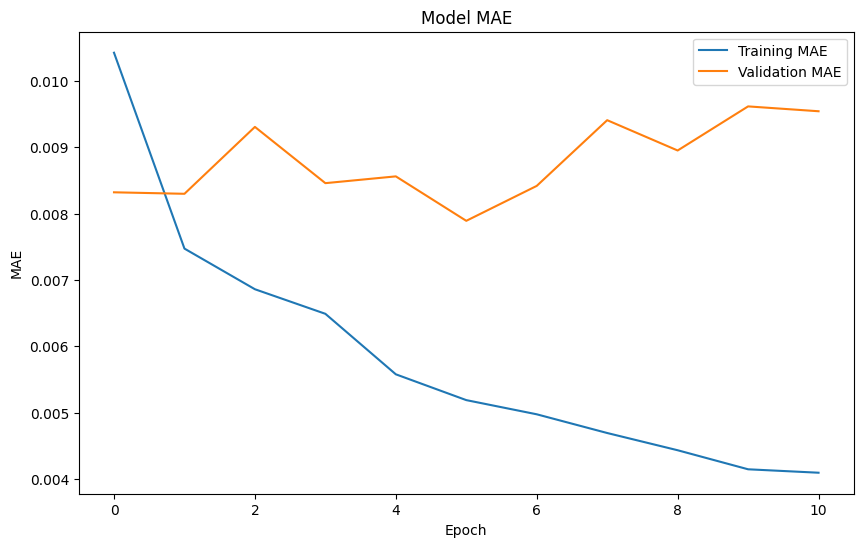

In [ ]:
# prompt: define a plot for mae/epoch

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training MAE')
plt.plot(history.history['val_loss'], label='Validation MAE')
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

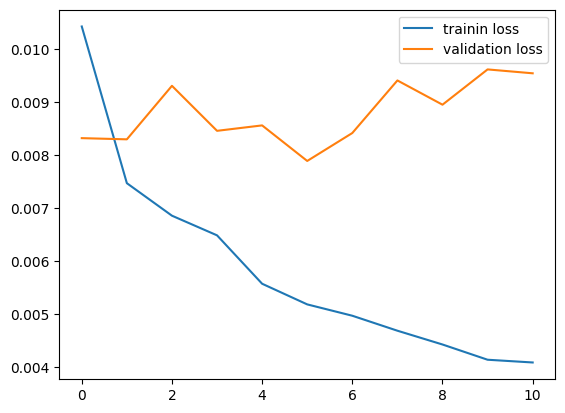

In [ ]:
plt.plot(history.history['loss'], label='trainin loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
forecast_period_dates=pd.date_range(list(train_dates)[-1], periods=n_future, freq='h').tolist()


In [ ]:
print(forecast_period_dates)

[Timestamp('2022-02-24 06:00:00'), Timestamp('2022-02-24 07:00:00'), Timestamp('2022-02-24 08:00:00'), Timestamp('2022-02-24 09:00:00'), Timestamp('2022-02-24 10:00:00'), Timestamp('2022-02-24 11:00:00'), Timestamp('2022-02-24 12:00:00'), Timestamp('2022-02-24 13:00:00'), Timestamp('2022-02-24 14:00:00'), Timestamp('2022-02-24 15:00:00'), Timestamp('2022-02-24 16:00:00'), Timestamp('2022-02-24 17:00:00'), Timestamp('2022-02-24 18:00:00'), Timestamp('2022-02-24 19:00:00'), Timestamp('2022-02-24 20:00:00'), Timestamp('2022-02-24 21:00:00'), Timestamp('2022-02-24 22:00:00'), Timestamp('2022-02-24 23:00:00'), Timestamp('2022-02-25 00:00:00'), Timestamp('2022-02-25 01:00:00'), Timestamp('2022-02-25 02:00:00'), Timestamp('2022-02-25 03:00:00'), Timestamp('2022-02-25 04:00:00'), Timestamp('2022-02-25 05:00:00'), Timestamp('2022-02-25 06:00:00'), Timestamp('2022-02-25 07:00:00'), Timestamp('2022-02-25 08:00:00'), Timestamp('2022-02-25 09:00:00'), Timestamp('2022-02-25 10:00:00'), Timestamp('20

In [ ]:
type
(forecast_period_dates)

[Timestamp('2022-02-24 06:00:00'),
 Timestamp('2022-02-24 07:00:00'),
 Timestamp('2022-02-24 08:00:00'),
 Timestamp('2022-02-24 09:00:00'),
 Timestamp('2022-02-24 10:00:00'),
 Timestamp('2022-02-24 11:00:00'),
 Timestamp('2022-02-24 12:00:00'),
 Timestamp('2022-02-24 13:00:00'),
 Timestamp('2022-02-24 14:00:00'),
 Timestamp('2022-02-24 15:00:00'),
 Timestamp('2022-02-24 16:00:00'),
 Timestamp('2022-02-24 17:00:00'),
 Timestamp('2022-02-24 18:00:00'),
 Timestamp('2022-02-24 19:00:00'),
 Timestamp('2022-02-24 20:00:00'),
 Timestamp('2022-02-24 21:00:00'),
 Timestamp('2022-02-24 22:00:00'),
 Timestamp('2022-02-24 23:00:00'),
 Timestamp('2022-02-25 00:00:00'),
 Timestamp('2022-02-25 01:00:00'),
 Timestamp('2022-02-25 02:00:00'),
 Timestamp('2022-02-25 03:00:00'),
 Timestamp('2022-02-25 04:00:00'),
 Timestamp('2022-02-25 05:00:00'),
 Timestamp('2022-02-25 06:00:00'),
 Timestamp('2022-02-25 07:00:00'),
 Timestamp('2022-02-25 08:00:00'),
 Timestamp('2022-02-25 09:00:00'),
 Timestamp('2022-02-

In [ ]:
trainX[-n_future].shape

(168, 62)

In [ ]:
forecast=model.predict(trainX[-n_future:])

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [ ]:
print(forecast)
print(forecast.shape)

[[0.57128906]
 [0.5833528 ]
 [0.59679884]
 [0.6102345 ]
 [0.6226257 ]
 [0.6329241 ]
 [0.6405983 ]
 [0.64539874]
 [0.6474664 ]
 [0.6471592 ]
 [0.6454203 ]
 [0.64318943]
 [0.6412045 ]
 [0.63989615]
 [0.63936114]
 [0.63951445]
 [0.64020324]
 [0.6357649 ]
 [0.62615794]
 [0.6143625 ]
 [0.60345304]
 [0.59586227]
 [0.5927346 ]
 [0.5939115 ]
 [0.5983344 ]
 [0.604781  ]
 [0.61211216]
 [0.61908865]
 [0.6246954 ]
 [0.62819064]
 [0.62932354]
 [0.6281793 ]
 [0.62528753]
 [0.6212837 ]
 [0.6172143 ]
 [0.6135216 ]
 [0.61060023]
 [0.6087216 ]
 [0.607749  ]
 [0.6075444 ]
 [0.60783637]
 [0.6023369 ]
 [0.59162426]
 [0.57903314]
 [0.56793773]
 [0.56098807]
 [0.5590564 ]
 [0.56254697]
 [0.5705435 ]
 [0.58196044]
 [0.5952164 ]
 [0.6086748 ]
 [0.6208056 ]
 [0.63046587]
 [0.6368309 ]
 [0.6396139 ]
 [0.63891375]
 [0.6355487 ]
 [0.63088226]
 [0.6265224 ]
 [0.6237595 ]
 [0.62318707]
 [0.6247513 ]
 [0.6280441 ]
 [0.6324818 ]
 [0.6317321 ]
 [0.6256505 ]
 [0.61658746]
 [0.6069108 ]
 [0.5984551 ]
 [0.5927347 ]
 [0.59

In [ ]:
forecast_copies=np.repeat(forecast, scaled_df.shape[1], axis=-1)

In [ ]:
forecast_copies.shape

(720, 62)

In [ ]:
y_pred_nem=scaler.inverse_transform(forecast_copies)[:,3]

In [ ]:
print(y_pred_nem)

[60.9873   62.085102 63.308693 64.531334 65.658936 66.59609  67.29444
 67.731285 67.91944  67.89149  67.733246 67.530235 67.3496   67.230545
 67.18186  67.195816 67.25849  66.85461  65.98037  64.90698  63.914223
 63.223465 62.938843 63.045948 63.448425 64.035065 64.7022   65.33707
 65.84728  66.165344 66.26844  66.164314 65.90116  65.53681  65.166504
 64.83046  64.56462  64.39366  64.30515  64.28654  64.31311  63.812653
 62.837807 61.692013 60.68233  60.04991  59.87413  60.191772 60.91946
 61.958397 63.16469  64.389404 65.49331  66.37239  66.951614 67.204865
 67.14115  66.83493  66.410286 66.013535 65.762115 65.71002  65.85237
 66.152016 66.55584  66.48762  65.9342   65.10946  64.22888  63.459408
 62.938854 62.74564  62.90035  63.369358 64.066666 64.86563  65.63699
 66.27419  66.718445 66.92722  66.90966  66.72004  66.4208   66.10336
 65.83175  65.64924  65.57477  65.608154 65.738525 65.398766 64.61071
 63.620052 62.666508 61.979336 61.658592 61.757286 62.23068  63.02053
 64.02222  65.

In [ ]:
print(y_pred_nem.shape)

(720,)


In [ ]:
y_pred_nem

array([60.9873  , 62.085102, 63.308693, 64.531334, 65.658936, 66.59609 ,
       67.29444 , 67.731285, 67.91944 , 67.89149 , 67.733246, 67.530235,
       67.3496  , 67.230545, 67.18186 , 67.195816, 67.25849 , 66.85461 ,
       65.98037 , 64.90698 , 63.914223, 63.223465, 62.938843, 63.045948,
       63.448425, 64.035065, 64.7022  , 65.33707 , 65.84728 , 66.165344,
       66.26844 , 66.164314, 65.90116 , 65.53681 , 65.166504, 64.83046 ,
       64.56462 , 64.39366 , 64.30515 , 64.28654 , 64.31311 , 63.812653,
       62.837807, 61.692013, 60.68233 , 60.04991 , 59.87413 , 60.191772,
       60.91946 , 61.958397, 63.16469 , 64.389404, 65.49331 , 66.37239 ,
       66.951614, 67.204865, 67.14115 , 66.83493 , 66.410286, 66.013535,
       65.762115, 65.71002 , 65.85237 , 66.152016, 66.55584 , 66.48762 ,
       65.9342  , 65.10946 , 64.22888 , 63.459408, 62.938854, 62.74564 ,
       62.90035 , 63.369358, 64.066666, 64.86563 , 65.63699 , 66.27419 ,
       66.718445, 66.92722 , 66.90966 , 66.72004 , 

In [ ]:
y_pred_nem

array([60.9873  , 62.085102, 63.308693, 64.531334, 65.658936, 66.59609 ,
       67.29444 , 67.731285, 67.91944 , 67.89149 , 67.733246, 67.530235,
       67.3496  , 67.230545, 67.18186 , 67.195816, 67.25849 , 66.85461 ,
       65.98037 , 64.90698 , 63.914223, 63.223465, 62.938843, 63.045948,
       63.448425, 64.035065, 64.7022  , 65.33707 , 65.84728 , 66.165344,
       66.26844 , 66.164314, 65.90116 , 65.53681 , 65.166504, 64.83046 ,
       64.56462 , 64.39366 , 64.30515 , 64.28654 , 64.31311 , 63.812653,
       62.837807, 61.692013, 60.68233 , 60.04991 , 59.87413 , 60.191772,
       60.91946 , 61.958397, 63.16469 , 64.389404, 65.49331 , 66.37239 ,
       66.951614, 67.204865, 67.14115 , 66.83493 , 66.410286, 66.013535,
       65.762115, 65.71002 , 65.85237 , 66.152016, 66.55584 , 66.48762 ,
       65.9342  , 65.10946 , 64.22888 , 63.459408, 62.938854, 62.74564 ,
       62.90035 , 63.369358, 64.066666, 64.86563 , 65.63699 , 66.27419 ,
       66.718445, 66.92722 , 66.90966 , 66.72004 , 

In [ ]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.strftime('%Y-%m-%d %H:%M'))


</b>BURANIN CHECK EDILMESI LAZIM HANGI df_forecast DOGRU CALISACAK TEST EDEMEDIM<b>


In [ ]:
#df_forecast=pd.DataFrame(y_pred_future,columns=['NISPINEM'],index=forecast_dates)

In [ ]:

df_forecast=pd.DataFrame({'DATETIME':np.array(forecast_dates),'NISPINEM': y_pred_nem})
#df_forecast['DATETIME']=pd.to_datetime(df_forecast['DATETIME'])
df_forecast.set_index('DATETIME', inplace=True)
df_forecast.index = pd.to_datetime(df_forecast.index)

In [ ]:
df_forecast

,NISPINEM
DATETIME,
2022-02-24 06:00:00,60.987301
2022-02-24 07:00:00,62.085102
2022-02-24 08:00:00,63.308693
2022-02-24 09:00:00,64.531334
2022-02-24 10:00:00,65.658936
...,...
2022-03-26 01:00:00,75.515778
2022-03-26 02:00:00,74.882431
2022-03-26 03:00:00,74.303322


In [ ]:
# DataFrame'i CSV'ye kaydet
df_forecast.to_csv('df_forecast.csv')

# Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive')

# Dosyayı Drive'a yükle
!cp df_forecast.csv /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
original=pd.DataFrame({'NISPINEM':new_df['NISPINEM']})

In [ ]:
original.head()

,NISPINEM
DATETIME,
2016-01-01 00:00:00,96.0
2016-01-01 01:00:00,97.0
2016-01-01 02:00:00,94.0
2016-01-01 03:00:00,91.0
2016-01-01 04:00:00,98.0


In [ ]:
original.shape

(53911, 1)

In [ ]:
new_df.tail()

,RUZGARYON,RUZGARHIZ,SICKURU,NISPINEM,BASINCAKTUEL,BLT0CINS,BLT0YUK,AY,SAAT,MEVSIM,...,GHADISE0_RESHRA,GHADISE0_RESHRASN,GHADISE0_RESHSN,GHADISE0_RESHSNGR,GHADISE0_RESHSNRA,GHADISE0_RETS,GHADISE0_RETSGRRA,GHADISE0_RETSRA,GHADISE0_RETSSNGR,GHADISE0_RETSSNRA
DATETIME,,,,,,,,,,,,,,,,,,,,,
2022-02-24 02:00:00,139.5,5.0,15.049999,42.0,1010.900024,8.0,3500.0,2.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-24 03:00:00,99.0,3.5,15.900001,38.5,1010.599976,8.0,3500.0,2.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-24 04:00:00,185.0,3.5,16.100000,36.5,1010.599976,8.0,3500.0,2.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-24 05:00:00,99.0,1.5,15.200000,49.5,1011.049988,8.0,3500.0,2.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-02-24 06:00:00,300.0,11.0,12.000000,77.0,1011.599976,8.0,3500.0,2.0,6.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
original=original.loc[original.index >='2022-01-01 00:00']

In [ ]:
original.head()

,NISPINEM
DATETIME,
2022-01-01 00:00:00,73.0
2022-01-01 01:00:00,73.5
2022-01-01 02:00:00,76.5
2022-01-01 03:00:00,85.5
2022-01-01 04:00:00,77.0


In [ ]:
print("O :", original.index)
print("D :", df_forecast.index)

O : DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-02-23 21:00:00', '2022-02-23 22:00:00',
               '2022-02-23 23:00:00', '2022-02-24 00:00:00',
               '2022-02-24 01:00:00', '2022-02-24 02:00:00',
               '2022-02-24 03:00:00', '2022-02-24 04:00:00',
               '2022-02-24 05:00:00', '2022-02-24 06:00:00'],
              dtype='datetime64[ns]', name='DATETIME', length=1303, freq='h')
D : DatetimeIndex(['2022-02-24 06:00:00', '2022-02-24 07:00:00',
               '2022-02-24 08:00:00', '2022-02-24 09:00:00',
               '2022-02-24 10:00:00', '2022-02-24 11:00:00',
               '2022-02-24 12:00:00', '2022-02-24 13:00:00',
               '2022-02-24 14:00:00', '2

<Axes: xlabel='DATETIME', ylabel='NISPINEM'>

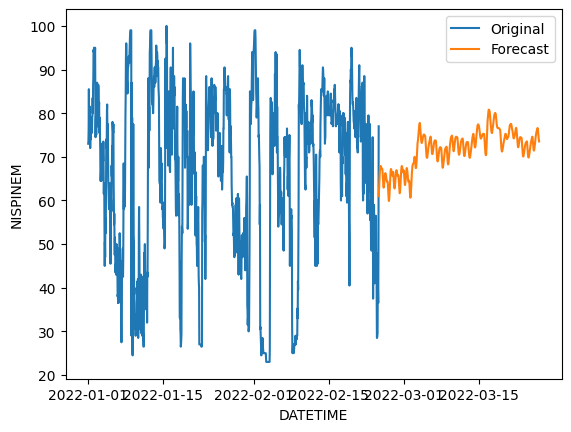

In [ ]:
# original ve df_forecast DataFrame'lerinin indeksinde DATETIME, sütunlarda ise NISPINEM bulunuyor.
sns.lineplot(x=original.index, y=original['NISPINEM'], label='Original')
sns.lineplot(x=df_forecast.index, y=df_forecast['NISPINEM'], label='Forecast')
